In [3]:
# Model Hyperparameters
layer_dims = [30,30]
saved = False

# Data Hyper-parameters 
pretrain_ratio = 0.15
dataset_percentage = 1.0

# Generalization Hyper-parameters
num_epsilon = 30
epsilon_max = 0.5
epsilon_min = 0.0001

num_alpha = 10
alpha_max = 1.0
alpha_min = 0.001

# Training Hyper-parameters
num_steps = 5000
lr = 0.01 
reg_eta = 1.0
batch_size = 100

# Fixed Constants
MNIST_PATH = './data/mnist'
num_classes = 10
channels = 1
height = 28
width = 28
in_dim = 784
full_size = 55000

In [2]:
# Parameters
#layer_dims = [100]
#dataset_percentage = 1.0
#reg_eta = 0.0
#pretrain_ratio = 0.05
#saved = False


## General Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid'] = False

import os 
import warnings
warnings.filterwarnings("ignore")

import pickle
from IPython.display import clear_output
from pathlib import Path
import time
import argparse

from collections import OrderedDict
import math 
import numpy as np
from PIL import Image

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import copy

clear_output()
torch.autograd.set_detect_anomaly(True)
torch.__version__

'1.11.0'

## Load Dataset 

Loading full training dataset
(60000, 28, 28)
(60000,)
Shuffling for a new experiment
Split into train and validation data
(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
Here are some example images
[1 6 3 6 7 2 4 1 1 5]
Normalizing data
Pretraining with a portion of the training data
Pretraining size is 8250
Batch size for emp risk is 46750


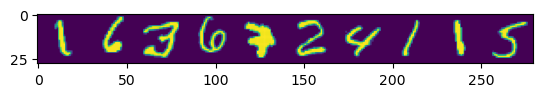

In [4]:
# Load dataset 
print("Loading full training dataset")
mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
train_images = mnist_train.train_data.numpy().astype(np.float32)
train_labels = mnist_train.train_labels.numpy().astype(np.int)
print(train_images.shape)
print(train_labels.shape)

# Shuffle the data for each experiment. 
# only run this cell once per trained model. 
print("Shuffling for a new experiment")
seed = np.random.randint(0, 10000)
np.random.seed(seed)
np.random.shuffle(train_images)
np.random.seed(seed)
np.random.shuffle(train_labels)

# Compute new size of dataset
dataset_size = int(dataset_percentage*full_size)
# Split into train and validation sets based on dataset_size
print("Split into train and validation data")
train_x, val_x = np.split(train_images, [dataset_size])
train_labels, val_labels = np.split(train_labels, [dataset_size])
print(train_x.shape, train_labels.shape)
print(val_x.shape, val_labels.shape)

# Show examples 
print("Here are some example images") 
example_images = np.concatenate(train_x[:10], axis=1)
example_labels = train_labels[:10]
print(example_labels)
plt.imshow(example_images)


# Helper function to normalize images to have mean 0 and stdev 1
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

print("Normalizing data")
train_images = normalize_stats_image_by_image(train_x)
val_images = normalize_stats_image_by_image(val_x)
    
pretrain_size = int(dataset_size*pretrain_ratio)
reduced_dataset_size = dataset_size-pretrain_size

if pretrain_ratio > 0.0: 
    print("Pretraining with a portion of the training data")
    print(f'Pretraining size is {pretrain_size}')
    print(f'Batch size for emp risk is {reduced_dataset_size}')
    pretrain_images = train_images[:pretrain_size]
    pretrain_labels = train_labels[:pretrain_size]
else:
    print("No pretraining")
    
batch_size=100

Loading test dataset
(10000, 28, 28)
(10000,)
Here are some example test images
[7 2 1 0 4 1 4 9 5 9]
Normalizing test images for evaluation


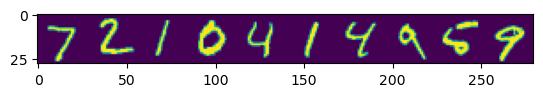

In [5]:
print("Loading test dataset")
mnist_test = torchvision.datasets.MNIST(str(MNIST_PATH), train=False, download=True)
test_images = mnist_test.test_data.numpy().astype(np.float32)
test_labels = mnist_test.test_labels.numpy().astype(np.int)
print(test_images.shape)
print(test_labels.shape)

print("Here are some example test images")
example_test_images = np.concatenate(test_images[:10], axis=1)
example_test_labels = test_labels[:10]
print(example_test_labels)
#print(example_test_images.shape)
plt.imshow(example_test_images)

print("Normalizing test images for evaluation")
test_images = normalize_stats_image_by_image(test_images)


Here are some example validation images
[5 4 6 7 1 7 4 7 9 5]


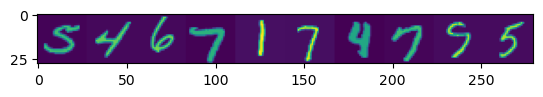

In [6]:
print("Here are some example validation images")
example_images = np.concatenate(val_images[:10], axis=1)
example_labels = val_labels[:10]
#print(example_images.shape)
plt.imshow(example_images)
print(example_labels)


In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device 

device(type='cuda')

In [8]:
def batch(batch_size, device='cuda', training=True, pretraining=False, post_train=False):
    if training:
        if pretraining:
            if not post_train:
                random_ind = np.random.choice(pretrain_size, size=batch_size, replace=False)
                input_batch = pretrain_images[random_ind]
                label_batch = pretrain_labels[random_ind]
            else:
                print(f'post-train sampling from pretraindata')
                input_batch = pretrain_images[:batch_size]
                label_batch = pretrain_labels[:batch_size]
        else:
            if pretraining: print(f'ALARMMM')
            if not post_train:
                #print(f'random sampling from full data')
                random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
                input_batch = train_images[random_ind]
                label_batch = train_labels[random_ind]
            else:
                print(f'sampling from full data')
                input_batch = train_images[:batch_size]
                label_batch = train_labels[:batch_size]
    else:
        #print(f'sampling from validation data')
        input_batch = val_images[:batch_size]
        label_batch = val_labels[:batch_size]
  
    input_batch = input_batch[:, np.newaxis, :, :]
  
    input_batch = torch.tensor(input_batch, requires_grad=False, device=device)
    label_batch = torch.tensor(label_batch, requires_grad=False, device=device)
  
    return input_batch, label_batch


In [9]:
def batch_test(batch_size, device='cuda'):
    input_batch = test_images[:batch_size]
    label_batch = test_labels[:batch_size]
  
    input_batch = input_batch[:, np.newaxis, :, :]
  
    input_batch = torch.tensor(input_batch, requires_grad=False, device=device)
    label_batch = torch.tensor(label_batch, requires_grad=False, device=device)
  
    return input_batch, label_batch


## Define Model Class

In [10]:
class Model(nn.Module):
    """A LeNet fully-connected model for MNIST"""

    def __init__(self, plan, outputs=10):
        super(Model, self).__init__()
        
        print("Initializing")
        self.num_layers = len(plan) 
        self.layers = []
        current_size = 784  # 28 * 28 = number of pixels in MNIST image.

        for size in plan:
            self.layers.append(nn.Linear(current_size, size, bias=False))
            current_size = size
        
        for i, layer in enumerate(self.layers):
            self.add_module(f"layer{i}", layer)            

        self.fc = nn.Linear(current_size, outputs, bias=False)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten.

        for i, layer in enumerate(self.layers):
            x = F.relu(self.layers[i](x))

        return self.fc(x)

class ForwardHookModel(nn.Module):
    def __init__(self, trained_model, output_layers, *args):
        super(ForwardHookModel, self).__init__(*args)
        self.output_layers = output_layers
        self.selected_out = OrderedDict()
        self.pretrained = trained_model
        self.fhooks = []

        self.selected_out.keys()

        for index, layer_name in enumerate(list(self.pretrained._modules.keys())):
            # print('\n index : {} \t layer name : {}'.format(index, layer_name))
            if index in self.output_layers:
                self.fhooks.append(
                    getattr(self.pretrained, layer_name).register_forward_hook(self.forward_hook(layer_name)))

    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output

        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

## Miscellaneous Helper functions

In [11]:
def get_path(layer_dims, data_str='mnist', prefix_str='weights', reg_eta = None, layer_index = None, dataset_percentage=1.0, pretrain_ratio=0.0):
    # prefix_str should be either - weights, training
    # path = './COLT_saved/mnist/500_500/base_reg_0d00_datasetp_0d8'
    folder_path = './COLT_saved/' + data_str + '/'
    
    layer_string=''
    for item in layer_dims:
        if layer_string == '':
            layer_string += str(item) 
        else:
            layer_string += '_' + str(item) 
    folder_path += layer_string + '/base'
    
    if pretrain_ratio > 0.0:
        pretrain_str = f'_{pretrain_ratio:.2f}'
        folder_path += '_pretrain' + pretrain_str.replace('.','d')
        
    if reg_eta is not None:
        reg_eta_str = f'_{reg_eta:.2f}'
        folder_path += '_reg' + reg_eta_str.replace('.','d')
    else:
        folder_path += '_zeroreg'
    
    dp_str = f'_{dataset_percentage:.2f}'
    folder_path += '_datasetp' + dp_str.replace('.','d')
    
    isExist = os.path.exists(folder_path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(folder_path)
    
    suffix_str = None
    if prefix_str == 'weights':
        suffix_str = '.pth' 
    elif prefix_str == 'training' or prefix_str == 'lipschitz' or prefix_str == 'radius':
        suffix_str = '.pdf'
    elif prefix_str == 'generalization_info':
        suffix_str = ''
    
    if suffix_str is None:
        raise ValueError(f'Invalid prefix string, given {prefix_str} but valid options = weights / training / generalization_info / radius / lipschitz')
    
    if prefix_str == 'radius':
        assert layer_index is not None
        prefix_str += '_layer' + str(layer_index)
    
    file_path = ''
    file_path += prefix_str  
    file_path += suffix_str
    
    return os.path.join(folder_path,file_path)
    

## Training Setup

In [12]:
def train_step(optimizer, batch_size=100, reg_eta = None, pretraining=False):
    
    model.train()
    input_batch, label_batch = batch(batch_size, training=True, pretraining=pretraining)
    output_batch = model(input_batch)
    
    loss = F.cross_entropy(output_batch, label_batch)
    _, pred_batch = torch.max(output_batch, dim=1)
    error_rate = 1.0 - (pred_batch == label_batch).float().mean()
    
    if reg_eta is not None:
        reg_loss = 0.0 
        for layer_index in range(model.num_layers):
            W = getattr(model, f'layer{layer_index}').weight
            W_diff = W-W_inits[layer_index]
            reg_loss += 1/(model.num_layers+1) * (torch.linalg.matrix_norm(W_diff,ord='fro') ** 2)
            
        W = getattr(model, 'fc').weight
        W_diff = W-W_inits[model.num_layers]
        reg_loss += 1/(model.num_layers+1) * (torch.linalg.matrix_norm(W_diff,ord='fro') ** 2)
        loss += reg_eta * reg_loss  
    else:
        reg_loss = 0.0 
        for layer_index in range(model.num_layers):
            W = getattr(model, f'layer{layer_index}').weight
            W_row_norm = torch.norm(W, p=2, dim=1)
            W_row_normalized = W.div(W_row_norm.expand_as(W.t()).t())
            W_gram_matrix = torch.matmul(W_row_normalized, W_row_normalized.t())
            sq_dim = W_gram_matrix.shape[0]
            identity = torch.Tensor(np.eye(sq_dim)).type(W.type()).to(W.device)
            reg_loss += 1/(model.num_layers+1) * torch.linalg.matrix_norm(identity - W_gram_matrix,ord='fro') ** 2
        
        W = getattr(model, 'fc').weight.t()
        W_row_norm = torch.norm(W, p=2, dim=1)
        W_row_normalized = W.div(W_row_norm.expand_as(W.t()).t())
        W_gram_matrix = torch.matmul(W_row_normalized, W_row_normalized.t())
        sq_dim = W_gram_matrix.shape[0]
        identity = torch.Tensor(np.eye(sq_dim)).type(W.type()).to(W.device)
        reg_loss += 1/(model.num_layers+1) * torch.linalg.matrix_norm(identity - W_gram_matrix,ord='fro') ** 2
        #loss += reg_loss 
    
    optimizer.zero_grad()
    loss.backward()
    clip_value = 5
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    optimizer.step()
  
    return loss.item(), error_rate.item()

def val():
  
    model.eval()
    input_batch, label_batch = batch(val_images.shape[0], training=False)
    output_batch = model(input_batch)

    loss = F.cross_entropy(output_batch, label_batch)
    _, pred_batch = torch.max(output_batch, dim=1)
    error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
    return loss.item(), error_rate.item()

In [13]:
def run_train(model, layer_dims, data_str = 'mnist', reg_eta=None, dataset_percentage=1.0, pretraining=False, num_steps = 5000, lr=0.01, pretrain_ratio=0.0):
    if not pretraining:
        model_path = get_path(layer_dims, data_str = 'mnist', prefix_str = 'weights', reg_eta = reg_eta, dataset_percentage=dataset_percentage, pretrain_ratio=pretrain_ratio)
        print(f'Model will be saved at {model_path}')
    else:
        print(f'Model will not be saved') 
        
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) #, weight_decay=0.1
    
    # for module in model.children():
    #     module.reset_parameters()

    info = []
    num_steps_per_val = 50
    best_val_err = 1.0
    for step in range(num_steps):
        is_nan = torch.stack([torch.isnan(p).any() for p in model.parameters()]).any()
        if is_nan: raise ValueError('The model parameters have nan!')
        train_loss, train_err = train_step(optimizer, reg_eta = reg_eta, pretraining=pretraining)
            
        if step % num_steps_per_val == 0:
            val_loss, val_err = val()
            if val_err < best_val_err:
                best_val_err = val_err
                print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
                # print('Step {:5d}: While training error is {:.3f}.'.format(step, train_err))
                info.append([step, train_loss, val_loss, train_err, val_err])
    
    x00, y11, y12, y21, y22 = zip(*info)
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(x00, y11, x00, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x00, y21, x00, y22)
    ax[1].legend(['Train err', 'Val err'])
    ax[1].set_ylim([0.0, 0.25])
    if not pretraining: 
        plot_path = get_path(layer_dims, data_str = 'mnist', prefix_str = 'training', reg_eta = reg_eta, dataset_percentage=dataset_percentage, pretrain_ratio=pretrain_ratio)
        print(f'Training plots will be saved at {plot_path}')            
        plt.savefig(plot_path, bbox_inches="tight")
        torch.save(model.state_dict(), model_path)
        

In [14]:
def get_model_weights(m):
    weights = []
    weights_norms_f = []
    weights_norms_o = []
    for layer_index in range(m.num_layers):
        temp = getattr(model, f'layer{layer_index}').weight.data
        weights.append(temp)
        weights_norms_f.append((torch.linalg.matrix_norm(temp, ord='fro'))**2)
        weights_norms_o.append((torch.linalg.matrix_norm(temp, ord=2))**2)
        del temp

    temp = getattr(m, 'fc').weight.data
    weights.append(temp)
    weights_norms_f.append((torch.linalg.matrix_norm(temp, ord='fro'))**2)
    weights_norms_o.append((torch.linalg.matrix_norm(temp, ord=2))**2)
    del temp
    
    return weights, weights_norms_f, weights_norms_o

## Instantiate Model
- Define based on layer_dims 
- Get model path
- Load or Train + Save

-------- PRETRAINING ------
Initializing
Model(
  (layer0): Linear(in_features=784, out_features=30, bias=False)
  (layer1): Linear(in_features=30, out_features=30, bias=False)
  (fc): Linear(in_features=30, out_features=10, bias=False)
)
Model will not be saved
Step     0: Obtained a best validation error of 0.893.
Step    50: Obtained a best validation error of 0.667.
Step   100: Obtained a best validation error of 0.585.
Step   150: Obtained a best validation error of 0.549.
Step   200: Obtained a best validation error of 0.452.
Step   250: Obtained a best validation error of 0.289.
Step   300: Obtained a best validation error of 0.229.
Step   350: Obtained a best validation error of 0.197.
Step   400: Obtained a best validation error of 0.168.
Step   450: Obtained a best validation error of 0.158.
Step   500: Obtained a best validation error of 0.148.
Step   550: Obtained a best validation error of 0.139.
Step   600: Obtained a best validation error of 0.127.
Step   700: Obtained a

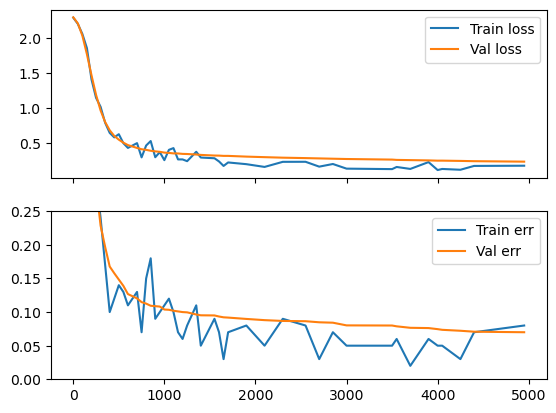

In [15]:
W_inits = None
W_init_norms_f = None
W_init_norms_o = None 
    
if pretrain_ratio > 0.0:
    print('-------- PRETRAINING ------')
    model = Model(layer_dims)
    print(model) 
    to_device(model, device)
    run_train(model, layer_dims, data_str = 'mnist', reg_eta=None, dataset_percentage = dataset_percentage, pretraining=True)

    W_inits, W_init_norms_f, W_init_norms_o = get_model_weights(model)
    print(W_init_norms_f)
    print(W_init_norms_o)

    state = {
        'model': model.state_dict()
    }
    model_save_path = './COLT_saved/mnist/temp.pth'
    torch.save(state, model_save_path)


Initializing
Model(
  (layer0): Linear(in_features=784, out_features=30, bias=False)
  (layer1): Linear(in_features=30, out_features=30, bias=False)
  (fc): Linear(in_features=30, out_features=10, bias=False)
)
Model linked to path : ./COLT_saved/mnist/30_30/base_pretrain_0d15_reg_1d00_datasetp_1d00/weights.pth
Pretrain ratio is 0.15
Regularization strength with pretrained model is 1.0
Learning rate is 0.01
Number of training steps is 5000
Loading pretrained weights
Norms of pretrained weights
[tensor(21.7797, device='cuda:0'), tensor(22.0531, device='cuda:0'), tensor(14.7954, device='cuda:0')]
[tensor(2.0881, device='cuda:0'), tensor(2.8085, device='cuda:0'), tensor(2.5416, device='cuda:0')]
Norms of reinitialized weights loaded from pretraining weights
[tensor(21.7801), tensor(22.0497), tensor(14.7956)]
[tensor(2.0881), tensor(2.8077), tensor(2.5417)]
Model will be saved at ./COLT_saved/mnist/30_30/base_pretrain_0d15_reg_1d00_datasetp_1d00/weights.pth
Step     0: Obtained a best vali

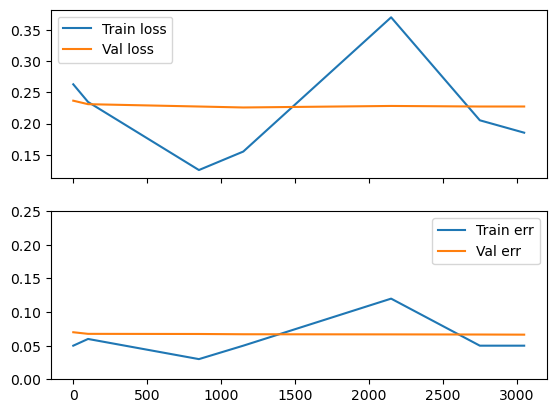

In [16]:
# Model (on GPU)
# del model 

model = Model(layer_dims)
print(model) 

model_path = get_path(layer_dims, data_str = 'mnist', prefix_str = 'weights', reg_eta = reg_eta, dataset_percentage = dataset_percentage, pretrain_ratio=pretrain_ratio)
print(f'Model linked to path : {model_path}') 
print(f'Pretrain ratio is {pretrain_ratio}')
print(f'Regularization strength with pretrained model is {reg_eta}')
print(f'Learning rate is {lr}')
print(f'Number of training steps is {num_steps}')

if pretrain_ratio == 0.:
    assert W_inits is None
    assert W_init_norms_f is None
    assert W_init_norms_o is None 
    
    print("Not using any pretrained weights")
    W_inits, W_init_norms_f, W_init_norms_o = get_model_weights(model)
    print(f'Norms of initialization weights')
    print(W_init_norms_f)
    print(W_init_norms_o) 

if pretrain_ratio > 0.0:
    assert W_inits is not None
    assert W_init_norms_f is not None
    assert W_init_norms_o is not None 
    
    print(f'Loading pretrained weights')
    state = torch.load('./COLT_saved/mnist/temp.pth')
    model.load_state_dict(state['model'])
    
    # this code adds gaussian noise but i dont need this. 
    for i, layer in enumerate(model.layers):
        layer.weight.data *= 1 + 0.001*torch.randn_like(layer.weight.data)
    model.fc.weight.data *= 1 + 0.0001*torch.randn_like(model.fc.weight.data)


    print(f'Norms of pretrained weights')
    print(W_init_norms_f)
    print(W_init_norms_o)

    print(f'Norms of reinitialized weights loaded from pretraining weights')
    _, a, b = get_model_weights(model) 
    print(a)
    print(b)

saved=False
if saved:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
    to_device(model, device)
else:
    to_device(model, device)
    run_train(model, layer_dims, data_str = 'mnist', reg_eta=reg_eta, dataset_percentage = dataset_percentage, num_steps=num_steps, lr=lr, pretrain_ratio=pretrain_ratio)

W_final, W_final_norms_f, W_final_norms_o = get_model_weights(model)
print(f'Frobenius norms of final trained weights : {W_final_norms_f}')
print(f'Operator norms of final trained weights : {W_final_norms_o}')

In [17]:
W_diff_norms = []
print("Computing difference in initialization vs trained networks")
for layer_index in range(len(W_inits)):
    #if W_final[layer_index].detach().cpu()
    print(f'\nIn layer {layer_index}')
    t1 = torch.linalg.matrix_norm(W_final[layer_index], ord='fro')**2
    print(f'Final norm is {t1}')
    t2 = torch.linalg.matrix_norm(W_inits[layer_index], ord='fro')**2
    print(f'Initial norm is {t2}')
    t3 = torch.sum(torch.abs(W_final[layer_index]-W_inits[layer_index]))
    print(f'Total absolute value difference is {t3}')
    t4 = torch.sum(W_final[layer_index]-W_inits[layer_index])
    print(f'Cumulative difference is {t4}')
    t5 = torch.linalg.matrix_norm(W_final[layer_index]-W_inits[layer_index], ord='fro')**2
    print(f'Norm of diff is {t5}')
    W_diff_norms.append(t5)

W_diff_norms

Computing difference in initialization vs trained networks

In layer 0
Final norm is 21.834360122680664
Initial norm is 21.7796630859375
Total absolute value difference is 12.62239933013916
Cumulative difference is -2.6226043701171875e-06
Norm of diff is 0.017059428617358208

In layer 1
Final norm is 22.110034942626953
Initial norm is 22.053142547607422
Total absolute value difference is 1.0367894172668457
Cumulative difference is -0.05193178355693817
Norm of diff is 0.0025954153388738632

In layer 2
Final norm is 14.853137016296387
Initial norm is 14.79540729522705
Total absolute value difference is 0.4050593674182892
Cumulative difference is 1.5534460544586182e-06
Norm of diff is 0.0013418112648651004


[tensor(0.0171, device='cuda:0'),
 tensor(0.0026, device='cuda:0'),
 tensor(0.0013, device='cuda:0')]

## Basic Evaluation 
- Instatiate batch 
- test standard accuracy
- report discrepancy
- Show orthogonal frame loss 
- Compute Global Parameter Lipschitz Constant 
- Compute Sparse Regularity

In [18]:
batch_size = 10000
x,y = batch_test(batch_size, device=device)
x = x.to(device)
y = y.to(device)


model = model.to(device)
model.eval()

output = model(x)
_, pred = torch.max(output, dim=1)
accuracy = (pred == y).float().mean()
#print(100*accuracy)
test_error = 1 - accuracy
print(f'Test error is {test_error}') 

Test error is 0.06420004367828369


In [19]:
batch_size = reduced_dataset_size
x,y = batch(dataset_size, device=device, training=True, post_train=True)
x = x.to(device)
y = y.to(device)

model = model.to(device)
model.eval()

output = model(x)
_, pred = torch.max(output, dim=1)
accuracy = (pred == y).float().mean()
#print(100*accuracy)
train_error = 1-accuracy
print(f'Total Train error is {train_error}')

print(f'\nExcluding pretraining')
restricted_accuracy = (pred[pretrain_size:] == y[pretrain_size:]).float().mean()
#print(100*accuracy)
restricted_train_error = 1-restricted_accuracy
print(f'Train error is {restricted_train_error}')

sampling from full data
Total Train error is 0.06303638219833374

Excluding pretraining
Train error is 0.06699460744857788


In [20]:
test_error - train_error

tensor(0.0012, device='cuda:0')

In [21]:
inp = x.view(x.shape[0],-1)
inp_norm = torch.max(torch.norm(inp, dim=1, p=2)).item()
inp_norm

28.0000057220459

In [22]:
selection = [layer_index for layer_index in range(model.num_layers)]
forward_model = ForwardHookModel(model, selection)
outputs, layer_outputs = forward_model(x)
len(outputs)
outputs.shape

torch.Size([55000, 10])

In [23]:
# del train_images, val_images, train_labels, val_labels, mnist_train

In [24]:
for key in layer_outputs.keys():
    print(key)
    #print(len(layer_outputs[key]))
    print(torch.max(torch.norm(layer_outputs[key], p=2, dim=1)))

print(torch.max(torch.norm(outputs,p=2,dim=1)))
print(torch.max(outputs))

layer0
tensor(27.6599, device='cuda:0', grad_fn=<MaxBackward1>)
layer1
tensor(33.1911, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(29.4030, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(19.4761, device='cuda:0', grad_fn=<MaxBackward1>)


In [25]:
def compute_margins(): 
    output = model(x)
    margins = []

    for input_index in range(dataset_size):
        if input_index < pretrain_size:
            continue
        target_label = y[input_index]
        target_output = output[input_index][target_label]
        temp = output[input_index].clone() 
        temp[target_label] = float("-inf")
        #print(torch.max(temp))
        margins.append(target_output - torch.max(temp.detach().cpu()))

    return margins

margins = compute_margins()
assert batch_size == len(margins)
print(sum(margins)/batch_size)

tensor(4.6135, device='cuda:0', grad_fn=<DivBackward0>)


## Parameter Lipschitz Constant 
- Global Parameter Lipschitz Bound
- Sparse Regularity Lipschitz Bound

In [26]:
def get_intermediate_norms():
    layer_reduced_babel = []
    layer_reduced_row_norms = []
    
    for layer_index in range(model.num_layers):
        print(f'Layer {layer_index}')
        W = getattr(model, f'layer{layer_index}').weight.detach()
        W_row_norm = torch.norm(W, p=2, dim=1)
        row_norms_sp = [0]*W.shape[1]
        print('computing row-norms')
        if layer_index == 0:
            row_norms_sp = [torch.max(W_row_norm).item()]*W.shape[1]
        else:
            sorted_hadamard = torch.sort(W*W, dim = 1, descending = True).values
                
            for s_in in range(W.shape[1]):
                row_norms_sp[s_in] = torch.sqrt(torch.max(torch.sum(sorted_hadamard[:, :W.shape[1]-s_in], dim=1))).item()
                
        # need to calculate mu_(s_out, s_in) (W). 
        # 1) for each w_i and w_j first compute max_{J_in} |w_i[J_in]^w_j[J_in]|
        # 2) for each w_i, compute sum of top-k of max_{J_in} |w_i[J_in]^w_j[J_in]| across j's not eq to i. 
        # 3) take max over w_i. 
        print('computing pos,neg tensors')
        pos_1 = torch.zeros(W.shape[0], W.shape[0], W.shape[1])
        neg_1 = torch.zeros(W.shape[0], W.shape[0], W.shape[1])
        for i in range(W.shape[0]):
                for j in range(W.shape[0]):
                    if i==j: continue
                    
                    pos_1[i,j] = torch.abs(torch.sort(W[i]*W[j], descending = True).values)
                    neg_1[i,j] = torch.abs(torch.sort(-W[i]*W[j], descending = True).values)
        
        print('computing reduced babel')
        reduced_babel = torch.zeros(W.shape[0], W.shape[1])
        for s_in in range(W.shape[1]):
            if s_in % 25 == 0:
                print(f'At input sparsity level {s_in}')
            
            # max reduced has shape torch.zeros(W.shape[0], W.shape[0])
            max_reduced_row_ip = torch.maximum(torch.sum(pos_1[:,:,:W.shape[1]-s_in], dim=2), torch.sum(neg_1[:,:, :W.shape[1]-s_in], dim=2)) 
            cumulative_reduced_row = torch.sort(max_reduced_row_ip, dim=1, descending=True).values
            
            for s_out in range(W.shape[0]-1):
                gerschgorin_radius = torch.sum(cumulative_reduced_row[:, :W.shape[0]-s_out-1], dim=1)
                reduced_babel[s_out, s_in] = torch.max(gerschgorin_radius)/(row_norms_sp[s_in]**2)
            
        
        layer_reduced_babel.append(reduced_babel.detach().cpu().numpy())
        layer_reduced_row_norms.append(row_norms_sp)
        
    W = getattr(model, 'fc').weight
    row_norms_sp = [0]*W.shape[1]
    sorted_hadamard = torch.sort(W*W, dim = 1, descending = True).values
    for s_in in range(W.shape[1]):
        row_norms_sp[s_in] = torch.sqrt(torch.max(torch.sum(sorted_hadamard[:, :W.shape[1]-s_in], dim=1))).item()
        
    layer_reduced_row_norms.append(row_norms_sp) 
    
    return layer_reduced_row_norms, layer_reduced_babel

In [27]:
layer_reduced_row_norms, layer_reduced_babel = get_intermediate_norms()

Layer 0
computing row-norms
computing pos,neg tensors
computing reduced babel
At input sparsity level 0
At input sparsity level 25
At input sparsity level 50
At input sparsity level 75
At input sparsity level 100
At input sparsity level 125
At input sparsity level 150
At input sparsity level 175
At input sparsity level 200
At input sparsity level 225
At input sparsity level 250
At input sparsity level 275
At input sparsity level 300
At input sparsity level 325
At input sparsity level 350
At input sparsity level 375
At input sparsity level 400
At input sparsity level 425
At input sparsity level 450
At input sparsity level 475
At input sparsity level 500
At input sparsity level 525
At input sparsity level 550
At input sparsity level 575
At input sparsity level 600
At input sparsity level 625
At input sparsity level 650
At input sparsity level 675
At input sparsity level 700
At input sparsity level 725
At input sparsity level 750
At input sparsity level 775
Layer 1
computing row-norms
com

In [28]:
def findnearest(list, threshold):
    low = 0
    high = len(list) - 1

    if list[high] < threshold:
        return -1, -1, -1

    while low < high:
        if (low == high - 1) and (list[low] <= threshold) and (list[high] >= threshold):
            break 

        middle = low + (high - low) // 2

        if list[middle] > threshold:
            high = middle - 1   
        elif list[middle] < threshold:
            low = middle + 1
    
    #print(f'Wanted value in list close to {threshold}, and got {list[high]}')
    return high, list[high], list[high]-threshold

In [29]:
num_eta = 100
eta_grid = np.linspace(0,1,num_eta)

def get_eta(): 
    layer_etas = [] 
    for layer_index in range(model.num_layers):
        print(f'Finding eta matrix at layer {layer_index}')
        reduced_babel = layer_reduced_babel[layer_index] 
        W = getattr(model, f'layer{layer_index}').weight.detach().cpu()
        eta = torch.zeros(W.shape[0], W.shape[1])
        diff = torch.zeros(W.shape[0], W.shape[1])
        
        for s_out in range(W.shape[0]-1):
            for s_in in range(W.shape[1]):
                normalized_babel = reduced_babel[s_out, s_in]/(W.shape[0]-s_out-1)
                if normalized_babel > 1:
                    raise ValueError(f'Warning something seriously wrong for ({s_out, s_in}) with normalized_babel {normalized_babel}')
                
                _, normalized_eta, diff[s_out,s_in] = findnearest(eta_grid, normalized_babel)
                eta[s_out, s_in] = normalized_eta*(W.shape[0]-s_out-1)
        layer_etas.append(eta) 
        print(f'At layer {layer_index}, the max diff is {torch.max(diff)}')
    return layer_etas 
    

In [30]:
layer_etas = get_eta()

Finding eta matrix at layer 0
At layer 0, the max diff is 0.010098944418132305
Finding eta matrix at layer 1
At layer 1, the max diff is 0.01009005680680275


In [31]:
def get_zetas(sparsity_levels, verbose=False):
    layer_zetas = [] 
    assert len(sparsity_levels) <= len(layer_dims)
    
    current = 1.0 * inp_norm
    if verbose: 
        print("Inside zeta function")
        print(f'sparsity levels are {sparsity_levels}')
        print(f'{len(sparsity_levels)}')
    
    for layer_index in range(len(sparsity_levels)):
        s_in = 0
        if layer_index > 0:
            s_in = sparsity_levels[layer_index-1]
        s_out = sparsity_levels[layer_index]

        row_scale = layer_reduced_row_norms[layer_index][s_in] * np.sqrt(1 + layer_etas[layer_index][s_out, s_in])
        current *= row_scale
        layer_zetas.append(current)
        
        if verbose:  
            print(f'Layer index is {layer_index} with sparsity {sparsity_levels[layer_index]}')
            print(layer_reduced_row_norms[layer_index][s_in])
            print(np.sqrt(1 + layer_etas[layer_index][s_out, s_in]))
            print(f'row reduced norm is {layer_reduced_row_norms[layer_index][s_in]}')
            print(f'babel function is {layer_etas[layer_index][s_out, s_in]}')
            print(f'row scale is {row_scale}')
        
    
    temp = 1.0 
    if len(sparsity_levels) == len(layer_dims):
        temp = layer_reduced_row_norms[len(layer_dims)][sparsity_levels[-1]]
        layer_zetas.append(current*temp)
        
    return layer_zetas, current*temp  

Sparse local Lipschitz scale plot will be saved at ./COLT_saved/mnist/30_30/base_pretrain_0d15_reg_1d00_datasetp_1d00/lipschitz.pdf


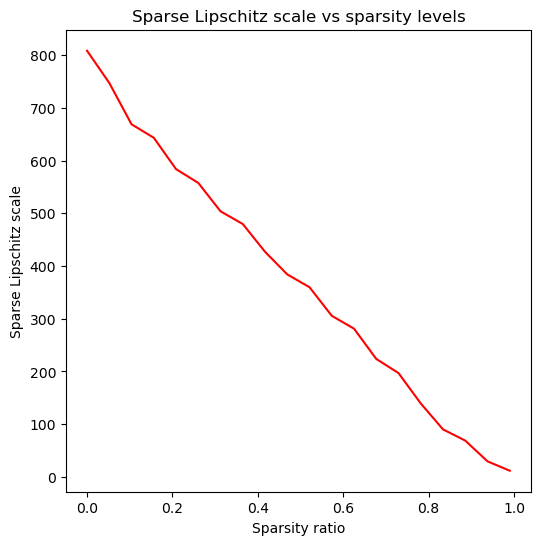

In [32]:
def plot_lip():
    num_ratios = 20
    s_ratios = np.linspace(0,0.99,num_ratios)
    lip = [0]*num_ratios 

    for (index,s) in enumerate(s_ratios):
        s_levels = []
        for d in layer_dims:
            s_levels.append(int(s*d))
        _, lip[index] = get_zetas(s_levels) # [s]*len(layer_dims)
    
    plot_path = get_path(layer_dims, data_str = 'mnist', prefix_str = 'lipschitz', reg_eta = reg_eta, dataset_percentage=dataset_percentage, pretrain_ratio=pretrain_ratio)
    print(f'Sparse local Lipschitz scale plot will be saved at {plot_path}')            
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(s_ratios[0:], lip[0:], color='red')
    plt.xlabel('Sparsity ratio')
    plt.ylabel('Sparse Lipschitz scale')
    plt.title('Sparse Lipschitz scale vs sparsity levels') 
    plt.savefig(plot_path, bbox_inches="tight")
        
plot_lip()

In [33]:
# Steps to compute bounds on generalization error 
# for layer k, input x, sparsity level s_k, s_{k-1}
# find sparse local radius r_k 
# Set radius thresholds based on epsilon. 
# for a fixed epsilon and an input, find maximal sparsity that satisfies it
# collect this across a batch of inputs 
# find quantiles based on alpha parameter. this gives controlled sparse loss (Verify this). 
# find margin at each input and set margin threshold. Evaluate margin risk w.r.t alpha-chosen sparsity level and epsilon. 
# find kl divergence/concentration terms. To do so, first define sigma-posterior and sigma-prior and evaluate the bound by adding up the expressions. 
# final bound = empirical risk + controlled sparse risk + concentration + kldivergence. 
# search for best epsilon and alpha. 


In [34]:
def layer_normalized_act(input_index, layer_index, sparsity_levels):
    # print(f'input index is {input_index}, layer_index is {layer_index} and sparsity levels are {sparsity_levels}')
    
    assert layer_index <= len(layer_dims) - 1
    assert len(sparsity_levels) == layer_index  
    
    if layer_index == 0:
        s_in = 0 
        zeta_in = inp_norm
    else: 
        s_in = sparsity_levels[-1] 
        _, zeta_in = get_zetas(sparsity_levels)
    
    row_norm = layer_reduced_row_norms[layer_index][s_in]
    
    current_key = f'layer{layer_index}'
    l_out = layer_outputs[current_key][input_index]

    denominator = row_norm * zeta_in  
    normalized_out = l_out.div(denominator)
    return normalized_out 

In [62]:
def layer_radius(input_index, layer_index, sparsity_levels):
    # print(f'Before calling normalized_act, input_index is {input_index}, layer_index is {layer_index} and sparsity vector is {sparsity_levels}')
    normalized_out = layer_normalized_act(input_index, layer_index, sparsity_levels[:-1])
    s_out = sparsity_levels[-1]
    if s_out == 0:
        sparse_radius = np.inf 
    else:
        sparse_radius = max(torch.sort(-normalized_out, descending=True).values[s_out-1].item(),0)

    return sparse_radius 

Sparse local radius plot at layer 0 will be saved at ./COLT_saved/mnist/30_30/base_pretrain_0d15_reg_1d00_datasetp_1d00/radius_layer0.pdf
Sparse local radius plot at layer 1 will be saved at ./COLT_saved/mnist/30_30/base_pretrain_0d15_reg_1d00_datasetp_1d00/radius_layer1.pdf


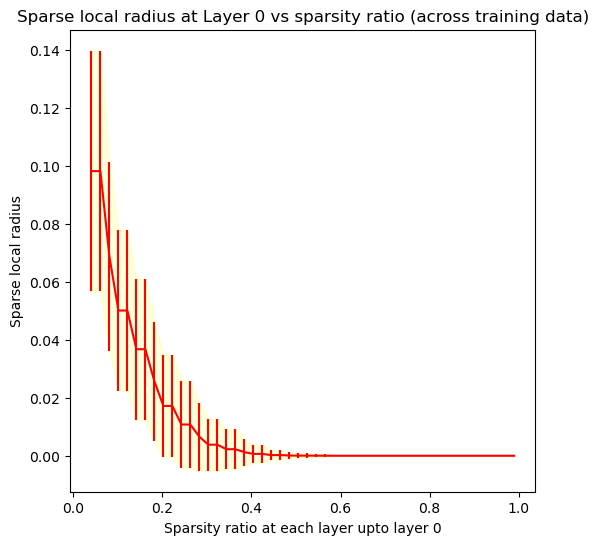

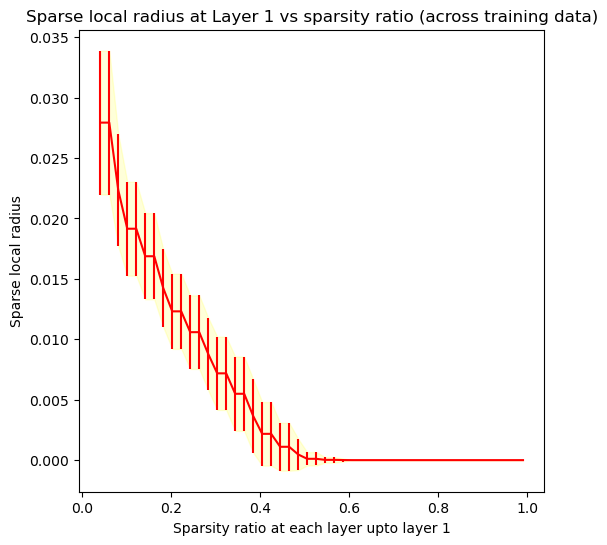

In [36]:
def plot_radius():
    num_examples = 1000
    num_layers = len(layer_dims) 
    num_ratios = 50
    all_radius = np.zeros((num_examples, num_ratios, num_layers))
    batch_sd = np.zeros((num_ratios, num_layers))
    batch_mean = np.zeros((num_ratios, num_layers))
    s_ratios = np.linspace(0,0.99,num_ratios)
    
    sparsity_stencil = []
    for j in range(num_ratios):
        s_levels = []
        for k in range(num_layers):
            s_levels.append(int(s_ratios[j]*layer_dims[k]))
        
        sparsity_stencil.append(s_levels)  
    
    for i in range(num_examples):
        for j in range(num_ratios):
            for k in range(num_layers):
                all_radius[i, j, k] = layer_radius(i, k, sparsity_stencil[j][:k+1])
    
    for k in range(num_layers):
        batch_sd[:,k] = all_radius[:,:,k].std(axis=0)
        batch_mean[:,k] = all_radius[:,:,k].mean(axis=0)   
    
    for k in range(num_layers):
        plot_path = get_path(layer_dims, data_str = 'mnist', prefix_str = 'radius', layer_index=k, reg_eta = reg_eta, dataset_percentage=dataset_percentage, pretrain_ratio=pretrain_ratio)
        print(f'Sparse local radius plot at layer {k} will be saved at {plot_path}')            
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.errorbar(s_ratios[1:], batch_mean[1:, k], yerr=batch_sd[1:, k], label='Average sparse local radius', color='red')
        ax.fill_between(s_ratios[1:], batch_mean[1:, k]-batch_sd[1:, k], batch_mean[1:, k]+batch_sd[1:, k], color='yellow', alpha=0.15)
        plt.title(f'Sparse local radius at Layer {k} vs sparsity ratio (across training data)')
        plt.ylabel(r'Sparse local radius')
        plt.xlabel(f'Sparsity ratio at each layer upto layer {k}')
        plt.savefig(plot_path, bbox_inches="tight")
        
plot_radius()

In [37]:
depth = len(layer_dims)+1
depth

3

In [38]:
def get_radius_thresholds(epsilon):
    gammas = []
    layer_epsilons = [] 
    gamma_prev = 0.0
    
    for layer_index in range(depth):
        eps_current = epsilon/(depth-layer_index)
        layer_epsilons.append(eps_current)
        
        gamma_prev = (1+eps_current)*gamma_prev + eps_current
        gammas.append(gamma_prev)
    
    return layer_epsilons, gammas

In [39]:
def greedy_sparsity_vector(input_index, epsilon): 
    sparsity_vector = [] 
    _, gammas = get_radius_thresholds(epsilon)
    #print(gammas)

    for layer_index in range(depth-1):
        normalized_out = layer_normalized_act(input_index, layer_index, sparsity_vector)
        sorted_out = torch.sort(-normalized_out).values
        threshold = 3*gammas[layer_index]    #-1 + (1 + (epsilon))**(layer_index + 1)
        high, radius, diff = findnearest(sorted_out, threshold)
        if high == -1:
            s = 0
        else: 
            s = len(normalized_out) - high 
        sparsity_vector.append(s) 
    
    return sparsity_vector

In [40]:
def collect_greedy(epsilon):
    greedy_sparsity_batch = np.zeros((batch_size, len(layer_dims)), dtype='i') 
    
    for input_index in range(batch_size):
        #print(f'Processing input {input_index}')
        greedy_sparsity_batch[input_index] = greedy_sparsity_vector(input_index, epsilon)
    
    return greedy_sparsity_batch

In [60]:
def collect_greedy_relax(epsilon, alpha, greedy_sparsity_batch = None):
    if greedy_sparsity_batch is None:
        greedy_sparsity_batch = collect_greedy(epsilon) 
    
    relaxed_sparsity = np.zeros(len(layer_dims),  dtype='i')
    for layer_index in range(len(layer_dims)):
        relaxed_sparsity[layer_index] = int(np.quantile(greedy_sparsity_batch[: , layer_index], 2*alpha/(depth * (depth-1))).astype(int))
    
    #relaxed_sparsity = [for x in relaxed_sparsity:
    return greedy_sparsity_batch, relaxed_sparsity    

In [42]:
batch_size

46750

In [43]:
def variance_normalization(d_in, d_out, s_in, s_out, delta, verbose=False):
    if verbose: 
        print('Inside variance normalization')
    expected_value = math.sqrt(d_out-s_out) + math.sqrt(d_in-s_in)
    deviation = math.sqrt(2)*math.sqrt(math.log( math.comb(d_in,s_in) ) + math.log( math.comb(d_out,s_out)) + math.log(1/delta))
    if verbose: 
        print(f'expected_value is {expected_value}')
        print(f'deviation is {deviation}')
    return expected_value + deviation 

In [44]:
def get_variance(sparsity_vector, layer_epsilons, verbose=False):
    sigma_prior = torch.zeros(len(layer_dims)+1) 
    sigma_posterior = torch.zeros(len(layer_dims)+1)
    delta = 1/(depth * math.sqrt(batch_size))

    for layer_index in range(len(layer_dims)+1):
        eps_current = layer_epsilons[layer_index] 
        if layer_index == 0:
            d_in = 784
            s_in = 0
            d_out = layer_dims[0] 
            s_out = sparsity_vector[0]
        elif layer_index == len(layer_dims):
            d_in = layer_dims[-1]
            s_in = sparsity_vector[-1]
            d_out = 10 
            s_out = 0
        else:
            d_in = layer_dims[layer_index-1]
            s_in = sparsity_vector[layer_index-1]
            d_out = layer_dims[layer_index] 
            s_out = sparsity_vector[layer_index]
        
        d_eff_1 = variance_normalization(d_in, d_out, s_in, s_out, delta)
        d_eff_2 = variance_normalization(d_in, d_out, s_in, d_out-1, delta)
        if verbose: 
            print(f'd_in = {d_in}, d_out = {d_out}, s_in = {s_in}, s_out = {s_out}, epsilon_k = {eps_current}, delta= {delta}')
            print(f'effective dimensions are {d_eff_1} and {d_eff_2}')
        
        babel = 1.0
        if layer_index < len(layer_dims):
            babel = math.sqrt(1+layer_reduced_babel[layer_index][s_out, s_in])
        
        sparse_norm = layer_reduced_row_norms[layer_index][s_in]* babel
        row_norm = layer_reduced_row_norms[layer_index][s_in]
        
        if verbose: 
            print(f'full frobenius norm is {W_final_norms_f[layer_index]} and full operator norm is {W_final_norms_o[layer_index]}')
            print(f'sparse norm is {sparse_norm} and row_norm is {row_norm}')
        
        v_1 = layer_reduced_row_norms[layer_index][s_in]* babel/ d_eff_1
        v_2 = layer_reduced_row_norms[layer_index][s_in]/ d_eff_2
        
        if verbose: 
            print(f'v1 is {v_1}, v2 is {v_2}')
        sigma_prior[layer_index] = min(v_1, v_2)
        sigma_posterior[layer_index] = eps_current * sigma_prior[layer_index] 
    
    return sigma_prior, sigma_posterior 



In [45]:
#sigma_prior, sigma_posterior = get_variance([350, 150], 0.001)
#print(sigma_prior) 

In [46]:
def layer_KL(layer_index, sigma, epsilon, verbose=False):
        if verbose: 
            print(f'\n Inside Layer KL, called with layer_ind : {layer_index}, sigma: {sigma}, epsilon: {epsilon}' )
        
        if layer_index == depth-1:
            key = 'fc'
        else:
            key = f'layer{layer_index}'
        
        W = getattr(model, key).weight.detach()
        W_fnorm = (W_diff_norms[layer_index])**2
        d1 = W.shape[0]
        d2 = W.shape[1]
        t= (torch.linalg.matrix_norm(W, ord='fro'))**2
        KL = W_fnorm/(2*(epsilon**2)*(sigma**2))
        KL_pc = W_fnorm/(2*(sigma**2)) + (d1*d2)*(epsilon**2 -0.5 + math.log(1/epsilon)) 
        
        if verbose: 
            print(f'W_fnorm is {W_fnorm}')
            print(f'Full norm was {t}')
            print(f'non PC KL divergence is {KL}')
            print(f'Parametercounting divergence is {KL_pc}')
        
        pc = False # Only set it to true if curious how the bound looks with parameter counting. 
        if pc:
            if verbose: print('returning PC div')
            return KL_pc
        else:
            if verbose: print('returning non PC div')
            return KL

In [47]:
depth

3

In [6]:
eps_grid = np.linspace(epsilon_min, epsilon_max, num_epsilon)
alpha_grid = np.linspace(alpha_min, alpha_max, num_alpha)

In [50]:
alpha_grid

array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ])

In [51]:
cum_sensitivity = np.zeros((num_epsilon, depth))
layerwise_epsilons = np.zeros((num_epsilon, depth)) 

zero_sparse_grid = np.zeros((num_epsilon))
bound_concentration_2 = np.zeros((num_epsilon))
bound_full_scale = np.zeros((num_epsilon))
bound_full_empirical_risk = np.zeros((num_epsilon))
bound_full_variance = np.zeros((num_epsilon, depth))
    
greedy_sparsity_eps_grid = np.zeros((num_epsilon, batch_size, len(layer_dims)), dtype='i')
greedy_relaxed_sparsity_eps_alpha_grid = np.zeros((num_epsilon, num_alpha, len(layer_dims)), dtype='i')
generalization_grid = np.zeros((num_epsilon, num_alpha))
sparse_empirical_risk = np.zeros((num_epsilon, num_alpha))
bound_sparse_kl_divergence = np.zeros((num_epsilon, num_alpha))
bound_sparse_margin_scale = np.zeros((num_epsilon, num_alpha))
bound_sparse_loss = np.zeros((num_epsilon, num_alpha))
bound_sparse_variance = np.zeros((num_epsilon, depth))
     
alpha_sparse_vecs = np.zeros((num_alpha, len(layer_dims)), dtype='i')
for alpha_index in range(num_alpha):
    alpha = alpha_grid[alpha_index]
    for layer_index in range(len(layer_dims)):
        d = layer_dims[layer_index]
        alpha_sparse_vecs[alpha_index, layer_index] = min(d-1,int(alpha*d))

In [52]:
depth

3

In [63]:
def tradeoff_eps_alpha(failure_delta = 0.1, verbose=False):
    for eps_index in range(num_epsilon):
        #eps_index = num_epsilon -1 -eps_index 
        epsilon = eps_grid[eps_index]
        layer_epsilons, gammas = get_radius_thresholds(epsilon)
        cum_sensitivity[eps_index] = gammas
        layerwise_epsilons[eps_index] = layer_epsilons
            
        _, full_scale  = get_zetas([0]*(depth-1))
        full_margin_threshold = 4 * full_scale * gammas[-1]

        full_margin_risk = torch.sum(torch.Tensor(margins) < full_margin_threshold).float()/batch_size
        
        if verbose: 
            print(f'Average margin is {torch.sum(torch.Tensor(margins))/batch_size}')
            print(f'Full Lipschitz scale is {full_scale}')
            print(f'Cumulative gamma with epsilon {epsilon} is {gammas[-1]}')
            print(f'Margin threshold with full scale is {full_margin_threshold}')
            
        concentration_1 = 2*depth/(math.sqrt(batch_size)-1)
        full_sigma_prior, full_sigma_posterior = get_variance([0]*(depth-1), layer_epsilons)
        full_layer_kl = []
        full_cumulative_kl = 0.0
        for layer_index in range(depth):
            layer_wise_kl = layer_KL(layer_index, full_sigma_prior[layer_index], layer_epsilons[layer_index])
            full_cumulative_kl += layer_wise_kl
            full_layer_kl.append(layer_wise_kl)  
        
        full_concentration_2 = 0.0
        grid_log = math.log(num_epsilon*num_alpha*num_eta)
        full_concentration_2 += math.sqrt(4* full_cumulative_kl + grid_log + 2*math.log(2*batch_size*depth/failure_delta)) / math.sqrt(batch_size-1)
        zero_sparse_grid[eps_index] = full_margin_risk + concentration_1 + full_concentration_2 
        
        bound_concentration_2[eps_index] = full_concentration_2
        bound_full_scale[eps_index] = full_scale
        bound_full_empirical_risk[eps_index] = full_margin_risk
        bound_full_variance[eps_index] = full_sigma_prior
        if verbose: 
            print(f'Margin empirical risk is {full_margin_risk}, concentration_1 is {concentration_1} and concentration_2 is {full_concentration_2}')
        
        print(f'\nZero sparse generalization bound for eps: {epsilon} is {zero_sparse_grid[eps_index]}')      
              
        greedy_sparsity_batch = collect_greedy(epsilon) 
        greedy_sparsity_eps_grid[eps_index] = greedy_sparsity_batch # to be indexed using eps_index
        for alpha_index in range(num_alpha):
            alpha = alpha_grid[alpha_index]
            _, greedy_relax_sparsity = collect_greedy_relax(epsilon, alpha, greedy_sparsity_batch = greedy_sparsity_batch) 
            greedy_relaxed_sparsity_eps_alpha_grid[eps_index, alpha_index] = greedy_relax_sparsity 
                
            _, sparse_scale  = get_zetas(alpha_sparse_vecs[alpha_index]) # greedy_relax_sparsity
            margin_threshold = 4 * sparse_scale * gammas[-1]
            if verbose: 
                print(f'Testing at sparsity level is {alpha_sparse_vecs[alpha_index]}') # greedy_relax_sparsity
                print(f'Sparse scale is {sparse_scale}')
                print(f'Margin threshold with sparse scale is {margin_threshold}')

            margin_risk = torch.sum(torch.Tensor(margins) < margin_threshold).float()/batch_size
            
            concentration_1 = 4*depth/(math.sqrt(batch_size)-1)
            cumulative_sparse_risk_1 = 0.0
            cumulative_sparse_risk_2 = 0.0
            
            for input_index in range(dataset_size):
                if input_index < pretrain_size:
                    continue
        
                # collect radiuses 
                layer_radii = []
                for layer_index in range(depth-1):
                    sparsity_levels = greedy_relax_sparsity[:layer_index+1]
                    rad = layer_radius(input_index, layer_index, sparsity_levels)
                    layer_radii.append(rad)

                    #if layer_index == depth-2:
                    
                #print(layer_radii)
                #print([item * 3 for item in gammas])
                
                for layer_index in range(depth-1):
                    satisfied_1 = True 
                    satisfied_2 = True
                    
                    for sub_layer_index in range(layer_index+1):
                        if layer_radii[sub_layer_index] < gammas[sub_layer_index]:
                            satisfied_1 = False
                        if layer_radii[sub_layer_index] < 3*gammas[sub_layer_index]:
                            satisfied_2 = False
                    
                    if not satisfied_1: 
                        cumulative_sparse_risk_1 += 1
                    if not satisfied_2: 
                        cumulative_sparse_risk_2 += 1
            
            cumulative_sparse_risk_1 = cumulative_sparse_risk_1/batch_size
            cumulative_sparse_risk_2 = cumulative_sparse_risk_2/batch_size
            
            concentration_2 = 0.0
            sigma_prior, sigma_posterior = get_variance(greedy_relax_sparsity, layer_epsilons)
            layer_kl = []
            for layer_index in range(depth):
                layer_kl.append(layer_KL(layer_index, sigma_prior[layer_index], layer_epsilons[layer_index]))  
    
            for layer_index in range(depth):
                cumulative_kl = 0.0
                for sub_layer_index in range(layer_index+1):
                    cumulative_kl += layer_kl[sub_layer_index]
                
                concentration_2 += math.sqrt(4* cumulative_kl + grid_log + 2*math.log(2*batch_size*depth/0.1)) / math.sqrt(batch_size-1)

            generalization_grid[eps_index, alpha_index] = margin_risk + cumulative_sparse_risk_1 + cumulative_sparse_risk_2 + concentration_1 + concentration_2
            sparse_empirical_risk[eps_index, alpha_index] = margin_risk
            bound_sparse_loss[eps_index, alpha_index] = cumulative_sparse_risk_1 + cumulative_sparse_risk_2
            bound_sparse_kl_divergence[eps_index, alpha_index] = concentration_2
            bound_sparse_margin_scale[eps_index, alpha_index] = sparse_scale
            bound_sparse_variance[eps_index] = sigma_prior 
              
            if verbose: 
                print(f'Margin empirical risk is {margin_risk}, sparse risks are {cumulative_sparse_risk_1, cumulative_sparse_risk_2}, concentration_1 is {concentration_1} and concentration_2 is {concentration_2}')
            print(f'Sparse generalization bound eps: {epsilon} and alpha: {alpha} and Greedy sparsity vector {greedy_relax_sparsity} is {generalization_grid[eps_index, alpha_index]}')
            # evaluate margin loss with margin threshold 

In [64]:
#%time tradeoff_eps_alpha()

In [65]:
result = %timeit -n1 -r1 -o tradeoff_eps_alpha(verbose=True)

Average margin is 4.6134867668151855
Full Lipschitz scale is 808.3304443359375
Cumulative gamma with epsilon 0.0001 is 0.0001833433335
Margin threshold with full scale is 0.5928080081939697
Margin empirical risk is 0.08902674168348312, concentration_1 is 0.027878775987216393 and concentration_2 is 97.76352279578249

Zero sparse generalization bound for eps: 0.0001 is 97.88042449951172
Testing at sparsity level is [0 0]
Sparse scale is 808.3304443359375
Margin threshold with sparse scale is 0.5928080081939697
Margin empirical risk is 0.08902674168348312, sparse risks are (0.005112299465240642, 0.006759358288770054), concentration_1 is 0.05575755197443279 and concentration_2 is 293.24785809357184
Sparse generalization bound eps: 0.0001 and alpha: 0.001 and Greedy sparsity vector [1 9] is 293.4045104980469
Testing at sparsity level is [3 3]
Sparse scale is 668.758056640625
Margin threshold with sparse scale is 0.49044933915138245


KeyboardInterrupt: 

In [67]:
print(result)
print(result.average)

NameError: name 'result' is not defined

In [69]:
info = OrderedDict() 

info_path = get_path(layer_dims, data_str = 'mnist', prefix_str = 'generalization_info', reg_eta = reg_eta, dataset_percentage=dataset_percentage, pretrain_ratio=pretrain_ratio) 
print(info_path)

#- what should I save ? 
config = OrderedDict()

# Model Hyperparameters
config['layer_dims'] = layer_dims

# Data hyperparameters
config['pretrain_ratio'] = pretrain_ratio
config['dataset_percentage'] = dataset_percentage

# Generalization Hyper-parameters
config['num_alpha'] = num_alpha
config['alpha_min'] = alpha_min 
config['alpha_max'] = alpha_max
config['num_epsilon'] = num_epsilon
config['epsilon_min'] = epsilon_min
config['epsilon_max'] = epsilon_max
config['num_eta'] = num_eta # always between 0 and 1. 
config['failure_delta'] = 0.1 

# Training Hyper-parameters
config['num_steps'] = num_steps
config['lr'] = lr 
config['training_batch_size'] = 100
config['reg_eta'] = reg_eta

info['config'] = config
info['test_error'] = test_error
info['train_error'] = train_error
info['margins'] = margins
info['eps_grid'] = eps_grid
info['alpha_grid'] = alpha_grid
info['eta_grid'] = eta_grid
info['layer_reduced_row_norms'] = layer_reduced_row_norms
info['layer_reduced_babel'] = layer_reduced_babel
info['layer_etas'] = layer_etas

info['cum_sensitivity'] = cum_sensitivity
info['layerwise_epsilons'] = layerwise_epsilons

info['zero_sparse_grid'] = zero_sparse_grid 
info['bound_concentration_2'] = bound_concentration_2
info['bound_full_scale'] = bound_full_scale
info['bound_full_empirical_risk'] = bound_full_empirical_risk
info['bound_full_variance'] = bound_full_variance

info['greedy_sparsity_eps_grid'] = greedy_sparsity_eps_grid 
info['greedy_relaxed_sparsity_eps_alpha_grid'] = greedy_relaxed_sparsity_eps_alpha_grid

info['generalization_grid'] = generalization_grid
info['sparse_empirical_risk'] = sparse_empirical_risk
info['bound_sparse_kl_divergence'] = bound_sparse_kl_divergence
info['bound_sparse_margin_scale'] = bound_sparse_margin_scale
info['bound_sparse_loss'] = bound_sparse_loss
info['bound_sparse_variance'] = bound_sparse_variance
     
info['alpha_sparse_vecs'] = alpha_sparse_vecs

./COLT_saved/mnist/30_30/base_pretrain_0d15_reg_1d00_datasetp_1d00/generalization_info


In [ ]:
with open(info_path, 'wb') as f:
    pickle.dump(info, f)
